In [1]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np
import re

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

rng = np.random.default_rng(12898)

SUPPORT_TAGS = ['DEFINITELY SUPPORT', 'SOMEWHAT SUPPORT']
OPPOSE_TAGS = ['DEFINITELY OPPOSE', 'SOMEWHAT OPPOSE']
ORDERED_TAGS = ['DEFINITELY SUPPORT', 'SOMEWHAT SUPPORT', 'SOMEWHAT OPPOSE', 'DEFINITELY OPPOSE']

APPROVE_TAGS = ['APPROVED', 'APPROVED IN PART OR WITH MODIFICATIONS']



## Data Preparation

In [2]:
dfa = dt.get_agenda_items(verbose=False)
dfm = dt.get_minutes(verbose=False)
dfl = dt.get_supplemental_docs(verbose=False)

In [3]:
# Keep only applications not withdrawn
idx = dfm['project_result']!='APPLICATION WITHDRAWN'
dfm = dfm.loc[idx].reset_index(drop=True)

In [4]:
# Keep only supporting or opposing letters
idx = dfl['support_or_oppose'].isin(SUPPORT_TAGS + OPPOSE_TAGS)
dfl = dfl.loc[idx].reset_index(drop=True)

In [5]:
# Count support and opposition for minutes items
for so in ['support', 'oppose']:
    for typ in ['', 'individual', 'official', 'other']:
        dfm[f'n_{typ}_{so}'] = 0
        
for idx, irow in dfm.iterrows():
    date = irow['date']
    item_no = irow['item_no']
    for jdx, jrow in dfl.loc[dfl['date']==date].iterrows():
        referenced_items = [s.strip() for s in jrow['referenced_items'].split(',')]
        is_so = {}
        is_so['support'] = jrow['support_or_oppose'] in SUPPORT_TAGS
        is_so['oppose'] = jrow['support_or_oppose'] in OPPOSE_TAGS
        is_type = {}
        is_type[''] = 1
        is_type['individual'] = 1*(jrow['author_type']=='INDIVIDUAL')
        is_type['official'] = 1*(jrow['author_type']=='PUBLIC OFFICIAL')
        is_type['other'] = 1 - is_type['individual'] - is_type['official']
        if item_no in referenced_items:
            for so in ['support', 'oppose']:
                for typ in ['', 'individual', 'official', 'other']:
                    dfm.loc[idx, f'n_{typ}_{so}'] += is_type[typ]*is_so[so]

In [6]:
# Deliberation order for minutes items
dfm['deliberation_order'] = dfm.groupby('date')[
    'minutes_start_line'
].rank(method='dense', ascending=True)

In [7]:
# Agenda item order
def split_item_no(x):
    match = re.match(r'(\d+)([a-zA-Z]*)', x)
    if match:
        return int(match.group(1)), match.group(2)
    else:
        return int(match.group(1)), ''

dfm[['item_no_num', 'item_no_sfx']] = dfm['item_no'].apply(lambda x: pd.Series(split_item_no(x)))

dfm['agenda_order'] = (
    dfm.sort_values(by=['date','item_no_num','item_no_sfx'])
       .groupby(['date'])
       .cumcount()+1
)

In [8]:
# Total number of agenda items for each meeting
tempdf = dfa.groupby('date').agg(num_agenda_items=('item_no','count')).reset_index()
dfm = dfm.merge(tempdf, on='date', how='left')

In [9]:
# consent calendar indicator
tempdf = dfa[['date', 'item_no', 'is_cc_part']]
dfm = dfm.merge(tempdf, on=['date', 'item_no'], how='left')
dfm['consent_calendar'] = 1*dfm['is_cc_part']

In [10]:
# agenda perplexity
tempdf = dfa[['date', 'item_no', 'perplexity']].rename(columns={'perplexity': 'agenda_perplexity'})
dfm = dfm.merge(tempdf, on=['date', 'item_no'], how='left')

In [11]:
# time to act
tempdf = dfa[['date', 'item_no', 'last_day_to_act']].copy()
tempdf['time_to_act'] = (tempdf['last_day_to_act'] - pd.to_datetime(tempdf['date'], errors='coerce')) / pd.to_timedelta(1,unit='D')
dfm = dfm.merge(tempdf, on=['date', 'item_no'], how='left')

In [12]:
# appealed
tempdf = dfa[['date', 'item_no', 'appealed']].copy()
dfm = dfm.merge(tempdf, on=['date', 'item_no'], how='left')
dfm['appealed'] = 1*dfm['appealed']

In [13]:
# number laws
tempdf = dfa[['date', 'item_no', 'relevant_laws']].copy()
tempdf['num_referenced_laws'] = tempdf['relevant_laws'].apply(lambda x: len(x.split('\n')))
dfm = dfm.merge(tempdf, on=['date', 'item_no'], how='left')

## Descriptive Data

In [14]:
# Results
dfm['project_result'].fillna('N/A').value_counts()

project_result
APPROVED                                  393
APPROVED IN PART OR WITH MODIFICATIONS    215
DELIBERATIONS CONTINUED TO FUTURE DATE    112
DENIED                                      7
Name: count, dtype: int64

In [15]:
# Support/oppose
dfl['support_or_oppose'].fillna('N/A').value_counts()

support_or_oppose
DEFINITELY OPPOSE     2131
DEFINITELY SUPPORT    1791
SOMEWHAT OPPOSE        300
SOMEWHAT SUPPORT       296
Name: count, dtype: int64

In [16]:
# Support/oppose by author type
dfl['support_or_oppose'] = pd.Categorical(
    dfl['support_or_oppose'], categories=ORDERED_TAGS, ordered=True
)
pd.crosstab(dfl['author_type'].fillna('N/A'), dfl['support_or_oppose'])

support_or_oppose,DEFINITELY SUPPORT,SOMEWHAT SUPPORT,SOMEWHAT OPPOSE,DEFINITELY OPPOSE
author_type,,,,
ADVOCACY GROUP,332,86,72,300
CONSULTANT,108,20,14,36
DEVELOPER,52,8,4,2
INDIVIDUAL,1054,149,170,1635
LAWYER,129,15,25,146
OTHER,14,2,5,7
PUBLIC OFFICIAL,102,16,10,5


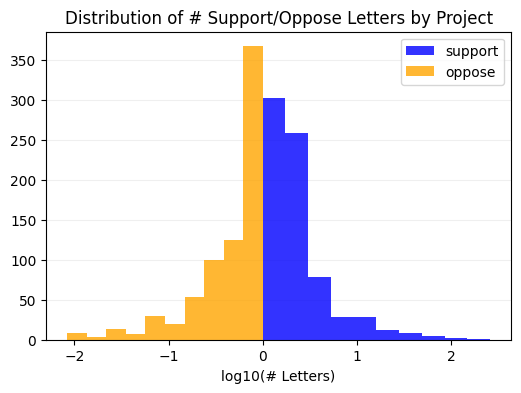

In [17]:
plt.figure(figsize=(6,4))
plt.hist(np.log10(dfm['n__support']+1), alpha=0.8, color='blue', label='support')
plt.hist(-np.log10(dfm['n__oppose']+1), alpha=0.8, color='orange', label='oppose')
plt.xlabel('log10(# Letters)')
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.gca().set_axisbelow(True)
plt.title("Distribution of # Support/Oppose Letters by Project")
plt.show()

In [19]:
for so in ['support', 'oppose']:
    for typ in ['', 'individual', 'official', 'other']:
        dfm[f'log2_{typ}_{so}'] = np.log(dfm[f'n_{typ}_{so}']+1)/np.log(2)

dfm['agenda_perplexity_z'] = (dfm['agenda_perplexity'] - dfm['agenda_perplexity'].mean())/dfm['agenda_perplexity'].std()
y = dfm['project_result'].isin(APPROVE_TAGS)

v1 = ['num_agenda_items']
v2 = ['consent_calendar', 'agenda_order', 'appealed']
v3 = ['agenda_perplexity_z']
v4 = ['num_referenced_laws']
v5 = ['log2__support', 'log2__oppose']

specs = [
    v1,
    v1 + v2,
    v1 + v2 + v3,
    v1 + v2 + v3 + v4,
    v1 + v2 + v3 + v4 + v5
]

xshow = ['const']
for spec in specs:
    for v in spec:
        if v not in xshow:
            xshow.append(v)

def reg(spec):
    X = sm.add_constant(dfm[spec])
    idx = ~y.isna()
    for col in X.columns:
        idx = idx & (~X[col].isna())
    regy = y.loc[idx].reset_index(drop=True)
    regX = X.loc[idx].reset_index(drop=True)
    return sm.Logit(regy, regX).fit()
    
models = [reg(spec) for spec in specs]

sg = Stargazer(models)
sg.covariate_order(xshow)
sg.title(title="Logit Regression: Success=Approved/Approved in part or with modifications")
sg

Optimization terminated successfully.
         Current function value: 0.445390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.427097
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.421519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.410600
         Iterations 8
